In [1]:
import nsepy

import pandas as pd
import datetime as dt

from Dashboards.helpers.nse import load_underlying, load_instrument_list, nse_load_options, get_lotsize

import numpy as np

from dateutil import relativedelta

import tqdm

import requests

import plotly.express as px

In [6]:
def calculate_period_delta(underlying_df, holding_period):
    underlying_df['adj_close'] = (underlying_df['High']+underlying_df['Low']+underlying_df['Close'])/3

    underlying_df['z_score'] = (underlying_df.Close-underlying_df.adj_close.rolling(holding_period, min_periods=1).mean())/underlying_df.adj_close.rolling(holding_period, min_periods=1).std()

    period_delta = pd.DataFrame({'z_score' : (underlying_df.Close-underlying_df.adj_close.rolling(holding_period).mean())/underlying_df.adj_close.rolling(holding_period).std(),
                                 'period_delta': (underlying_df['Close'] - underlying_df['Close'].shift(holding_period))/underlying_df['Close'].shift(holding_period),
                                 'delta_max': (underlying_df['High'] - underlying_df['Close'].shift(holding_period))/underlying_df['Close'].shift(holding_period),
                                 'delta_min': (underlying_df['Low'] - underlying_df['Close'].shift(holding_period))/underlying_df['Close'].shift(holding_period)})

    period_delta.z_score =period_delta.z_score.shift(-holding_period+1)

    period_delta = period_delta.dropna()
    
    return period_delta

In [2]:

def generate_pairs(pe_positions, ce_positions, brokerage=20):
    
    # Convert to dict for easier iteration
    pe_positions = pe_positions.to_dict(orient='records')
    ce_positions = ce_positions.to_dict(orient='records')
    
    position_pairs = []

    for pe_position in pe_positions:

        for ce_position in ce_positions:
            
            pair_cost = pe_position['position_cost'] + ce_position['position_cost']
            position_pair = {'cost': pair_cost+brokerage*4}
            position_pair['lot_size'] = pe_position['lot_size']
            position_pair['underlying_name'] = pe_position['Symbol']
            position_pair['expiry'] = pe_position['Expiry']
            position_pair['underlying_value'] = pe_position['Underlying']
            
            position_pair['pe_strike_price'] = pe_position['Strike Price']
            position_pair['ce_strike_price'] = ce_position['Strike Price']
            
            position_pair['pe_premium'] = pe_position['Close']
            position_pair['ce_premium'] = ce_position['Close']
            
            position_pair['pe_tpremium'] = pe_position['true_premium']
            position_pair['pe_tpremium_decay'] = pe_position['expected_true_premium_decay']
            
            position_pair['ce_tpremium'] = ce_position['true_premium']
            position_pair['ce_tpremium_decay'] = ce_position['expected_true_premium_decay']
            
            position_pair['spread'] = ce_position['Strike Price'] - pe_position['Strike Price']
            position_pair['breakeven'] = position_pair['cost']/position_pair['lot_size']
            position_pairs.append(position_pair)


    position_pairs = pd.DataFrame(position_pairs)

    # position_pairs['capital_breakeven_probability'] = 1-position_pairs['capital_not_breakeven_probability']
    return position_pairs

In [3]:
with open("datastore/nse.dataroot") as f:
    data_root = f.readline()
    print(data_root)

Qma38kW9X6VvJv7GewBE6pZ7NR2x9U9pALuTiXBRWAok8D


In [4]:
inst_list = load_instrument_list(data_root)

In [5]:
inst_list

['NIFTY',
 'BANKNIFTY',
 'DLF',
 'INFY',
 'HINDUNILVR',
 'HCLTECH',
 'TCS',
 'SBIN',
 'ASIANPAINT',
 'RELIANCE',
 'KOTAKBANK',
 'ITC',
 'ULTRACEMCO',
 'CIPLA',
 'POWERGRID',
 'JSWSTEEL',
 'GRASIM',
 'HINDALCO',
 'NMDC',
 'VEDL',
 'COALINDIA',
 'MPHASIS',
 'UPL',
 'GMRINFRA',
 'INDHOTEL',
 'COFORGE',
 'CHAMBLFERT',
 'AARTIIND',
 'LALPATHLAB',
 'PEL',
 'STAR']

In [7]:
holding_period = 4

In [7]:
all_underlying = []

indices = ['NIFTY', 'BANKNIFTY']
pbar = tqdm.tqdm(inst_list)


for inst in pbar:
    pbar.set_description(f'Downloading underlying for {inst}')
    underlying_df = load_underlying(inst, data_root)
    all_underlying.append(underlying_df)
    break

In [103]:
all_options = []
all_holding_period_delta = []
all_deltas = []
indices = ['NIFTY', 'BANKNIFTY']
pbar = tqdm.tqdm(inst_list)

for inst in pbar:
    pbar.set_description(f'Processing {inst}')
    
    if inst in indices:
        inst_type = 'FUTIDX'
    else:
        inst_type = 'FUTSTK'
    
    options_table, expiries = nse_load_options(inst, is_index=inst in indices)
    
    lot_size = int(get_lotsize(inst, is_index=inst in indices))
    underlying_df = load_underlying(inst, data_root)
    holding_period_delta = calculate_period_delta(underlying_df, holding_period)
    holding_period_delta['underlying_name'] = inst
    all_holding_period_delta.append(holding_period_delta)
    
    options_table = options_table[options_table['Close']>0]
    
    # Get last price of monthly future
    fut_expiry = dt.date.today()+relativedelta.relativedelta(day=31, weekday=relativedelta.TH(-1))
    fut_quote = nsepy.get_quote(symbol=inst, series='EQ', instrument=inst_type, expiry=fut_expiry)['data'][0]
    last_price = float(fut_quote['lastPrice'].replace(',', ''))
    
    options_table['lot_size']=lot_size
    options_table.Expiry = pd.to_datetime(options_table.Expiry)
    # min open interest == 10k
    options_table = options_table[(options_table.Expiry.dt.date>=(dt.date.today()+dt.timedelta(days=holding_period))) & (options_table.Expiry.dt.date<(dt.date.today()+dt.timedelta(days=31)))]
#     options_table = options_table[(options_table.Expiry.dt.date<(dt.date.today()+dt.timedelta(days=31)))]
    # there should be at least be 1 lot being traded
    options_table = options_table[options_table['Open Interest']>=0.1]
    options_table = options_table.sort_values('Expiry').reset_index(drop=True)
    
    
    for expiry in expiries:
        options_df = options_table[options_table['Expiry']==expiry]
        if len(options_df)==0:
            continue
        trade_days_left = np.busday_count(dt.date.today(), expiry.date())
        period_delta = calculate_period_delta(underlying_df, trade_days_left)
        
        
        ce_df = options_df[options_df['Option Type']=='CE'].sort_values('Strike Price').reset_index(drop=True)
        ce_df['break_even_delta'] = ((ce_df['Close']+ce_df['Strike Price']) - last_price)/last_price
        ce_df['p_condition_breakeven'] = 0
        ce_df['p_breakeven'] = 0

        for ix, ce_row in ce_df.iterrows():
            ce_df.loc[ix, 'p_condition_breakeven'] = ((period_delta.delta_max>ce_row['break_even_delta']) & (period_delta.z_score>period_delta.z_score[-1])*0.9).mean()
            ce_df.loc[ix, 'p_breakeven'] = (period_delta.delta_max>ce_row['break_even_delta']).mean()

        ce_df['kelly_fraction'] = ce_df['p_breakeven']-(1-ce_df['p_breakeven'])/1.1
        
        pe_df = options_df[options_df['Option Type']=='PE'].sort_values('Strike Price').reset_index(drop=True)
        pe_df['break_even_delta'] = ((pe_df['Strike Price'] -  pe_df['Close'])- last_price)/last_price
        pe_df['p_condition_breakeven'] = 0
        pe_df['p_breakeven'] = 0

        for ix, pe_row in pe_df.iterrows():
            pe_df.loc[ix, 'p_condition_breakeven'] = ((period_delta.delta_min<pe_row['break_even_delta']) & (period_delta.z_score<(period_delta.z_score[-1])*1.1)).mean()
            pe_df.loc[ix, 'p_breakeven'] = (period_delta.delta_min<pe_row['break_even_delta']).mean()
        
        pe_df['kelly_fraction'] = pe_df['p_breakeven']-(1-pe_df['p_breakeven'])/1.1
        
        all_options.extend([ce_df, pe_df])  
        
        period_delta['trade_days_left'] = trade_days_left
        period_delta['underlying_name'] = inst
        all_deltas.append(period_delta)
        


Processing STAR: 100%|██████████| 31/31 [02:25<00:00,  4.70s/it]      


In [104]:
all_options = pd.concat(all_options, ignore_index=True)

all_options['true_premium'] = 0
ce_mask = all_options['Option Type']=='CE'
all_options.loc[ce_mask, 'true_premium'] =  all_options.loc[ce_mask, 'Close'] + (all_options.loc[ce_mask, 'Strike Price']-all_options.loc[ce_mask, 'Underlying'])
pe_mask = all_options['Option Type']=='PE'
all_options.loc[pe_mask, 'true_premium'] = all_options.loc[pe_mask, 'Close'] + (all_options.loc[pe_mask, 'Underlying']-all_options.loc[pe_mask, 'Strike Price'])

In [105]:
", ".join(all_options['Symbol'].unique())

'NIFTY, BANKNIFTY, DLF, INFY, HINDUNILVR, HCLTECH, TCS, SBIN, ASIANPAINT, RELIANCE, KOTAKBANK, ITC, ULTRACEMCO, CIPLA, POWERGRID, JSWSTEEL, GRASIM, HINDALCO, NMDC, VEDL, COALINDIA, MPHASIS, UPL, GMRINFRA, INDHOTEL, COFORGE, CHAMBLFERT, AARTIIND, LALPATHLAB, PEL, STAR'

In [106]:
all_deltas = pd.concat(all_deltas)

all_holding_period_delta = pd.concat(all_holding_period_delta)

In [107]:
all_options['position_cost'] = all_options['Close']*all_options['lot_size']

all_options['expected_true_premium_decay'] = all_options['true_premium']/np.busday_count(dt.date.today(), all_options['Expiry'].dt.date)

all_options['tp_decay_delta'] = (all_options['break_even_delta']*all_options['Underlying'] - all_options['expected_true_premium_decay']*holding_period)/all_options['Underlying']

In [108]:
all_options.sort_values('p_breakeven', ascending=False).head()

,Strike Price,Expiry,Option Type,Symbol,identifier,Open Interest,Change in OI,Change % in OI,Number of Contracts,impliedVolatility,...,Underlying,lot_size,break_even_delta,p_condition_breakeven,p_breakeven,kelly_fraction,true_premium,position_cost,expected_true_premium_decay,tp_decay_delta
2,16800.0,2022-01-13,CE,NIFTY,OPTIDXNIFTY13-01-2022CE16800.00,158.0,102.0,182.142857,80,0.0,...,17757.35,50,-0.004484,0.038579,0.784772,0.589109,-41.00,45817.5,-10.2500,-0.002175
4,16950.0,2022-01-13,CE,NIFTY,OPTIDXNIFTY13-01-2022CE16950.00,36.0,15.0,71.428571,28,0.0,...,17757.35,50,-0.004012,0.038579,0.779695,0.579419,-32.60,38737.5,-8.1500,-0.002176
6,17050.0,2022-01-13,CE,NIFTY,OPTIDXNIFTY13-01-2022CE17050.00,91.0,38.0,71.698113,44,0.0,...,17757.35,50,-0.003357,0.036548,0.767513,0.556161,-20.95,34320.0,-5.2375,-0.002178
212,34000.0,2022-01-13,CE,BANKNIFTY,OPTIDXBANKNIFTY13-01-2022CE34000.00,104.0,78.0,300.000000,185,0.0,...,37590.65,25,-0.006245,0.037602,0.767276,0.555710,-123.35,86682.5,-30.8375,-0.002964
304,40500.0,2022-01-13,PE,BANKNIFTY,OPTIDXBANKNIFTY13-01-2022PE40500.00,5.0,5.0,0.000000,16,0.0,...,37590.65,25,0.011197,0.744919,0.762195,0.546009,-534.25,59377.5,-133.5625,0.025409


P(Breakeven |  Premium decay till expiry )

In [109]:
all_options['p_tp_breakeven'] = 0
for underlying in all_options['Symbol'].unique():
    period_delta = all_holding_period_delta[(all_holding_period_delta['underlying_name'] == underlying)]
    options_df = all_options[all_options['Symbol']==underlying]
    all_options.loc[(all_options['Symbol']==underlying) & (all_options['Option Type']=='CE'), 'p_tp_breakeven'] = options_df.loc[options_df['Option Type']=='CE','tp_decay_delta'].map(lambda x: (x<period_delta['delta_max']).mean())
    all_options.loc[(all_options['Symbol']==underlying) & (all_options['Option Type']=='PE'), 'p_tp_breakeven'] = options_df.loc[options_df['Option Type']=='PE','tp_decay_delta'].map(lambda x: (x>period_delta['delta_min']).mean())

In [110]:
ce_otm_mask =  ((all_options['Option Type']=='CE') & (all_options['Strike Price']>all_options['Underlying']))

pe_otm_mask =  ((all_options['Option Type']=='PE') & (all_options['Strike Price']<all_options['Underlying']))

otm_mask = ((all_options['Option Type']=='CE') & (all_options['Strike Price']>all_options['Underlying'])) | ((all_options['Option Type']=='PE') & (all_options['Strike Price']<all_options['Underlying']))

In [111]:
relevant_col = ['Symbol', 'Strike Price', 'Expiry', 'Option Type',
                'Open Interest', 'Change in OI', 'Number of Contracts', 
                'impliedVolatility', 'Close', 'Change', 'Underlying', 'lot_size',
                'break_even_delta', 'p_condition_breakeven', 'p_breakeven',
                'kelly_fraction', 'true_premium', 'expected_true_premium_decay',
                'tp_decay_delta', 'p_tp_breakeven', 'position_cost']

In [112]:
all_options = all_options[relevant_col].copy()

Since true premium should go to zero by expiry

P(Breakeven |  Premium decay till expiry )

In [113]:
all_options['p_tp_breakeven'] = 0
for _, row in all_options[['Symbol', 'Expiry']].drop_duplicates().iterrows():
    days = np.busday_count(dt.date.today(), row['Expiry'].date())
    period_delta = all_deltas[(all_deltas['underlying_name'] == row['Symbol']) & (all_deltas['trade_days_left']==days)]
    options_df = all_options[(all_options['Symbol']==row['Symbol']) & (all_options['Expiry']==row['Expiry'])]
    all_options['p_tp_breakeven'] = options_df['tp_decay_delta'].map(lambda x: (x>period_delta['period_delta']).mean())
    all_options.loc[(all_options['Symbol']==row['Symbol']) & (all_options['Expiry']==row['Expiry']), 'p_tp_breakeven'] = options_df['tp_decay_delta'].map(lambda x: (x>period_delta['period_delta']).mean())

In [114]:
today = dt.date.today()

In [115]:
all_pairs = []
for _, contract_expiry in all_options[['Symbol', 'Expiry']].drop_duplicates().iterrows():
    options_mask = (all_options['Symbol']==contract_expiry['Symbol']) & (all_options['Expiry']==contract_expiry['Expiry'])
    pairs = generate_pairs(all_options[options_mask&pe_otm_mask],all_options[options_mask&ce_otm_mask])
    if len(pairs) == 0:
        continue
    period_delta = all_holding_period_delta[(all_holding_period_delta['underlying_name'] == underlying)].reset_index()
    pairs['target'] = 1.1*pairs['breakeven']
    pairs['pe_breakeven_delta'] = ((pairs['pe_strike_price']-pairs['target']) - pairs['underlying_value'])/pairs['underlying_value']
    pairs['ce_breakeven_delta'] = ((pairs['ce_strike_price']+pairs['target']) - pairs['underlying_value'])/pairs['underlying_value']
    p_pe_vol_be = pairs['pe_breakeven_delta'].map(lambda x:(period_delta['delta_min']<=x).mean())
    p_ce_vol_be = pairs['ce_breakeven_delta'].map(lambda x:(period_delta['delta_max']>=x).mean())
    pairs['p_not_breakeven_volatility'] = (1-p_ce_vol_be)*(1-p_pe_vol_be)
    
    p_pe_tp_be = ((pairs['target']-(holding_period*(pairs['pe_tpremium_decay']+pairs['ce_tpremium_decay'])/2))/pairs['underlying_value']).map(lambda x:(period_delta['delta_min']<=x).mean())
    p_ce_tp_be = ((pairs['target']-(holding_period*(pairs['pe_tpremium_decay']+pairs['ce_tpremium_decay'])/2))/pairs['underlying_value']).map(lambda x:(period_delta['delta_max']>=-x).mean())
    pairs['p_not_breakeven_tp'] = (1-p_ce_tp_be)*(1-p_pe_tp_be)
    all_pairs.append(pairs)

all_pairs = pd.concat(all_pairs)

In [116]:
all_pairs['p_dist'] = np.sqrt(all_pairs.p_not_breakeven_tp**2 + all_pairs.p_not_breakeven_volatility**2)

all_pairs['spread_percent'] = (all_pairs['target']+all_pairs['spread'])/all_pairs['underlying_value']

all_pairs['kelly_fraction'] = (1-all_pairs['p_not_breakeven_volatility']) - all_pairs['p_not_breakeven_tp']/(0.1)

In [117]:
disp_filter = (all_pairs['p_not_breakeven_tp']<.5) & (all_pairs['p_not_breakeven_volatility']<.5) & (all_pairs['p_not_breakeven_tp']<all_pairs['p_not_breakeven_volatility'])

In [118]:
kelly_capital_filter = (all_pairs['kelly_fraction']>=(0.9*all_pairs['cost']/100000)) & (all_pairs['kelly_fraction']>0)

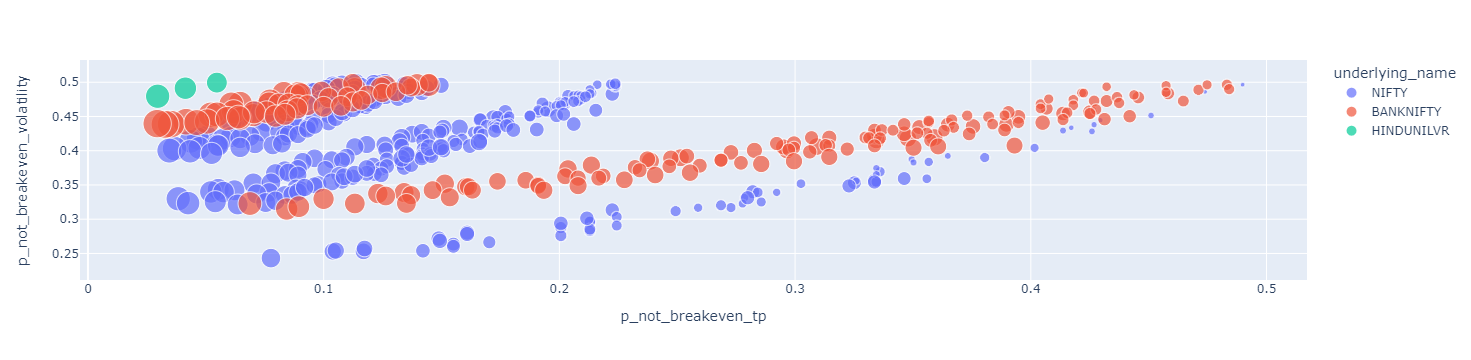

In [119]:
fig = px.scatter(all_pairs[disp_filter], 
                 x='p_not_breakeven_tp', y='p_not_breakeven_volatility', 
                 size='cost', color='underlying_name', 
                 hover_data=['expiry', 'underlying_value', 'kelly_fraction',
                             'ce_strike_price', 'pe_strike_price', 'spread_percent',
                             'ce_premium', 'pe_premium', 
                             'target', 'cost'])

fig.show()

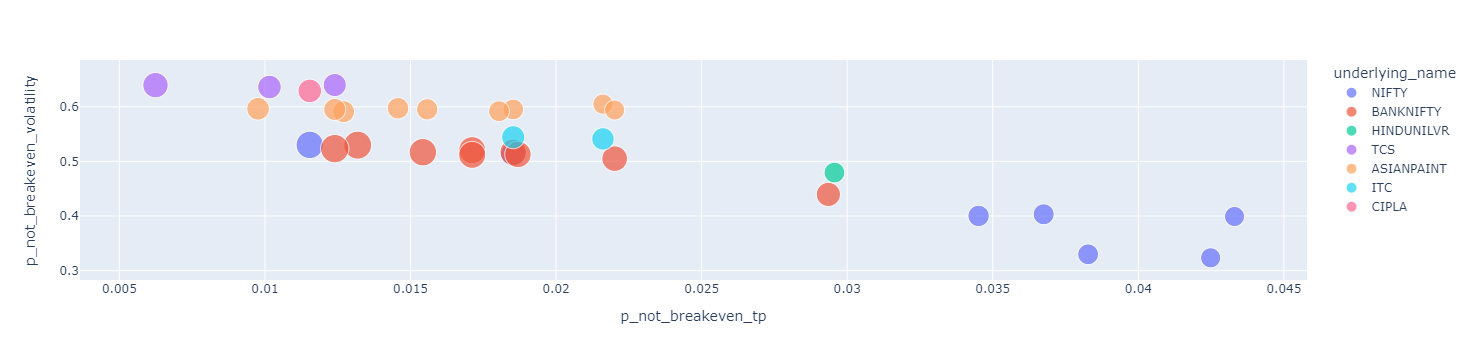

In [120]:
fig = px.scatter(all_pairs[kelly_capital_filter], 
                 x='p_not_breakeven_tp', y='p_not_breakeven_volatility', 
                 size='cost', color='underlying_name', 
                 hover_data=['expiry', 'underlying_value', 'kelly_fraction',
                             'ce_strike_price', 'pe_strike_price', 'spread_percent',
                             'ce_premium', 'pe_premium', 
                             'target', 'cost'])

fig.show()

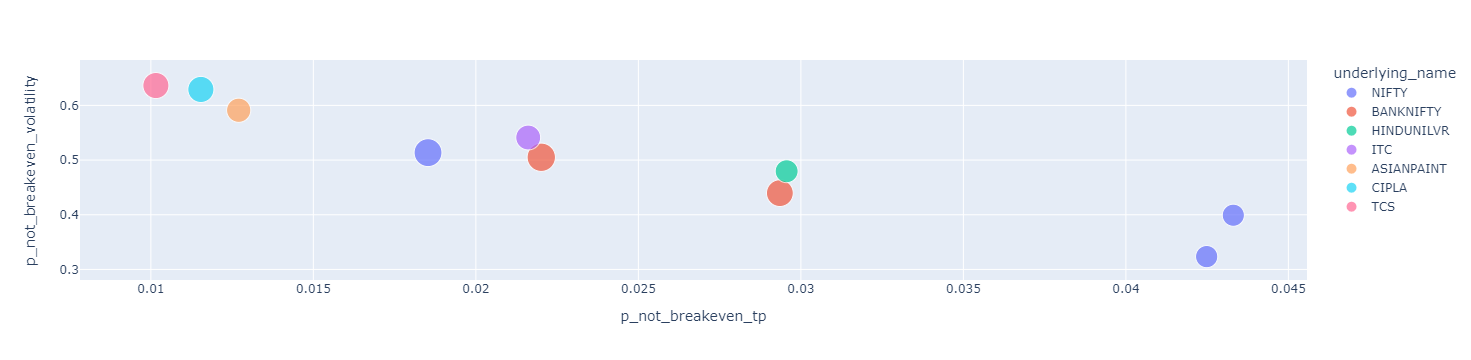

In [121]:
fig = px.scatter(all_pairs[kelly_capital_filter].sort_values('p_dist').drop_duplicates(['underlying_name', 'expiry']),
                 x='p_not_breakeven_tp', y='p_not_breakeven_volatility', 
                 size='cost', color='underlying_name', 
                 hover_data=['expiry', 'underlying_value', 'kelly_fraction',
                             'ce_strike_price', 'pe_strike_price', 'spread_percent',
                             'ce_premium', 'pe_premium', 
                             'target', 'cost'])

fig.show()

In [186]:
all_pairs[disp_filter].groupby(['underlying_name', 'expiry']).agg({'ce_strike_price':'max',
                                                                   'pe_strike_price':'min',
                                                                   'underlying_value':'max',
                                                                   'spread':'max'})

ce_strike_price  pe_strike_price  \
underlying_name expiry                                         
AARTIIND        2022-01-27           1060.0            940.0   
ASIANPAINT      2022-01-27           3660.0           3260.0   
BANKNIFTY       2022-01-13          37000.0          36800.0   
                2022-01-20          38000.0          35600.0   
                2022-01-27          38700.0          34800.0   
CHAMBLFERT      2022-01-27            445.0            340.0   
CIPLA           2022-01-27           1010.0            840.0   
COALINDIA       2022-01-27            168.5            140.0   
COFORGE         2022-01-27           7000.0           5800.0   
DLF             2022-01-27            445.0            335.0   
GMRINFRA        2022-01-27             52.0             45.0   
GRASIM          2022-01-27           1820.0           1560.0   
HCLTECH         2022-01-27           1450.0           1210.0   
HINDALCO        2022-01-27            510.0            470.0   
HINDUNILVR      2022-01-27           2460.0           2360.0   
INDHOTEL        2022-01-27            197.5            160.0   
INFY            2022-01-27           2080.0           1800.0   
ITC             2022-01-27            232.0            206.0   
JSWSTEEL        2022-01-27            730.0            620.0   
KOTAKBANK       2022-01-27           1980.0           1720.0   
LALPATHLAB      2022-01-27           3950.0           3300.0   
MPHASIS         2022-01-27           3700.0           3000.0   
NIFTY           2022-01-20          17850.0          17550.0   
                2022-01-27          18200.0          17350.0   
                2022-02-03          18300.0          16900.0   
NMDC            2022-01-27            147.5            127.5   
PEL             2022-01-27           2900.0           2350.0   
POWERGRID       2022-01-27            217.5            205.0   
RELIANCE        2022-01-27           2600.0           2340.0   
SBIN            2022-01-27            505.0            440.0   
STAR            2022-01-27            500.0            440.0   
TCS             2022-01-27           4220.0           3540.0   
UPL             2022-01-27            820.0            710.0   
VEDL            2022-01-27            370.0            305.0   

                            underlying_value  spread  
underlying_name expiry                                
AARTIIND        2022-01-27            993.00   100.0  
ASIANPAINT      2022-01-27           3454.25   240.0  
BANKNIFTY       2022-01-13          36840.15   200.0  
                2022-01-20          36840.15  1300.0  
                2022-01-27          36840.15  2300.0  
CHAMBLFERT      2022-01-27            409.50    70.0  
CIPLA           2022-01-27            925.00    90.0  
COALINDIA       2022-01-27            153.00    16.0  
COFORGE         2022-01-27           6112.00   900.0  
DLF             2022-01-27            394.50    60.0  
GMRINFRA        2022-01-27             48.40     5.0  
GRASIM          2022-01-27           1692.00   140.0  
HCLTECH         2022-01-27           1335.50   130.0  
HINDALCO        2022-01-27            476.00    40.0  
HINDUNILVR      2022-01-27           2405.95   100.0  
INDHOTEL        2022-01-27            184.80    27.5  
INFY            2022-01-27           1901.00   180.0  
ITC             2022-01-27            219.80    16.0  
JSWSTEEL        2022-01-27            670.10    60.0  
KOTAKBANK       2022-01-27           1852.60   140.0  
LALPATHLAB      2022-01-27           3829.45   550.0  
MPHASIS         2022-01-27           3395.00   400.0  
NIFTY           2022-01-20          17805.25   300.0  
                2022-01-27          17805.25   550.0  
                2022-02-03          17805.25  1100.0  
NMDC            2022-01-27            135.85    12.5  
PEL             2022-01-27           2669.60   350.0  
POWERGRID       2022-01-27            210.40    12.5  
RELIANCE        2022-01-27           2460.00   160.0  
SBIN            20

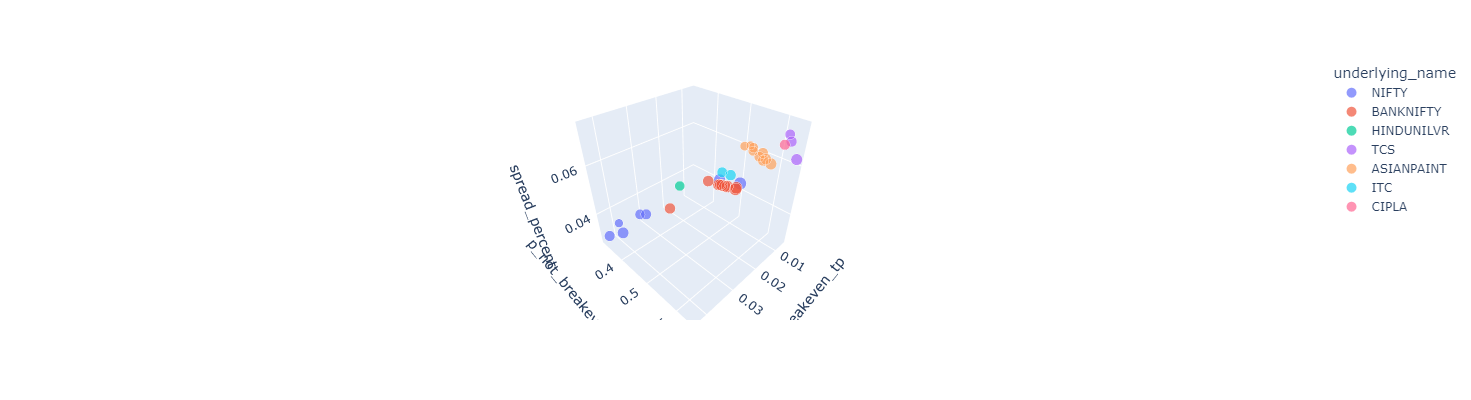

In [123]:
fig = px.scatter_3d(all_pairs[kelly_capital_filter], 
                    x='p_not_breakeven_tp', y='p_not_breakeven_volatility', z='spread_percent',
                    size='kelly_fraction', color='underlying_name', 
                    hover_data=['expiry', 'underlying_value',
                                'ce_strike_price', 'pe_strike_price', 'spread_percent',
                                'ce_premium', 'pe_premium', 
                                'target', 'cost'],
                   height=400
                   )

fig.show()

In [105]:
all_pairs[((1-all_pairs['p_not_breakeven_volatility']) - all_pairs['p_not_breakeven_tp']/(0.1))>0]

,cost,lot_size,underlying_name,expiry,underlying_value,pe_strike_price,ce_strike_price,pe_premium,ce_premium,pe_tpremium,...,ce_tpremium_decay,spread,breakeven,target,pe_breakeven_delta,ce_breakeven_delta,p_not_breakeven_volatility,p_not_breakeven_tp,p_dist,spread_percent
120,18967.50,50,NIFTY,2022-01-20,17805.25,17750.0,17850.0,175.00,202.75,230.25,...,20.625000,100.0,379.350000,417.285000,-0.026539,0.025949,0.304889,0.059577,0.310655,0.029052
425,19130.00,50,NIFTY,2022-01-27,17805.25,17450.0,17850.0,119.10,261.90,474.35,...,18.038235,400.0,382.600000,420.860000,-0.043589,0.026150,0.376055,0.060950,0.380962,0.046102
442,20420.00,50,NIFTY,2022-01-27,17805.25,17550.0,17850.0,144.90,261.90,400.15,...,18.038235,300.0,408.400000,449.240000,-0.039566,0.027744,0.373462,0.055706,0.377594,0.042080
459,21137.50,50,NIFTY,2022-01-27,17805.25,17600.0,17850.0,159.25,261.90,364.50,...,18.038235,250.0,422.750000,465.025000,-0.037645,0.028631,0.369181,0.054134,0.373128,0.040158
460,18457.50,50,NIFTY,2022-01-27,17805.25,17600.0,17950.0,159.25,208.30,364.50,...,20.767647,350.0,369.150000,406.065000,-0.034333,0.030936,0.370921,0.060950,0.375895,0.042463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,39562.50,850,AARTIIND,2022-01-27,993.00,970.0,1020.0,23.00,23.45,46.00,...,2.967647,50.0,46.544118,51.198529,-0.074722,0.078750,0.704310,0.019119,0.704569,0.101912
6,23323.75,125,LALPATHLAB,2022-01-27,3829.45,3600.0,3850.0,45.00,140.95,274.45,...,9.500000,250.0,186.590000,205.249000,-0.113515,0.058964,0.712025,0.019499,0.712292,0.118881
20,36902.50,275,PEL,2022-01-27,2669.60,2550.0,2700.0,43.90,90.00,163.50,...,7.082353,150.0,134.190909,147.610000,-0.100094,0.066680,0.719611,0.017068,0.719814,0.111481
25,44740.00,275,PEL,2022-01-27,2669.60,2650.0,2700.0,72.40,90.00,92.00,...,7.082353,50.0,162.690909,178.960000,-0.074378,0.078424,0.703197,0.007978,0.703242,0.085766


In [502]:
all_pairs.groupby(['underlying_name', 'expiry']).agg({'p_dist':'min', 'p_not_breakeven_volatility':'min'})

p_dist  p_not_breakeven_volatility
underlying_name expiry                                          
AARTIIND        2022-01-27  0.652970                    0.646429
ASIANPAINT      2022-01-27  0.489979                    0.486871
BANKNIFTY       2022-01-13  0.335053                    0.325648
                2022-01-20  0.401633                    0.397031
                2022-01-27  0.462869                    0.459944
                2022-02-03  0.701012                    0.685467
CHAMBLFERT      2022-01-27  0.713371                    0.709776
CIPLA           2022-01-27  0.579677                    0.573676
COALINDIA       2022-01-27  0.575318                    0.575049
COFORGE         2022-01-27  0.772006                    0.771185
DLF             2022-01-27  0.714031                    0.707031
GMRINFRA        2022-01-27  0.756442                    0.751652
GRASIM          2022-01-27  0.585949                    0.582244
HCLTECH         2022-01-27  0.622700                    0.613167
HINDALCO        2022-01-27  0.607441                    0.604103
HINDUNILVR      2022-01-27  0.432717                    0.429318
INDHOTEL        2022-01-27  0.724080                    0.723033
INFY            2022-01-27  0.598218                    0.595818
ITC             2022-01-27  0.500976                    0.499993
JSWSTEEL        2022-01-27  0.601448                    0.599008
KOTAKBANK       2022-01-27  0.551567                    0.549976
LALPATHLAB      2022-01-27  0.681168                    0.672462
MPHASIS         2022-01-27  0.703654                    0.699414
NIFTY           2022-01-13  0.276646                    0.257362
                2022-01-20  0.312257                    0.306511
                2022-01-27  0.350320                    0.343809
                2022-02-03  0.489465                    0.487092
NMDC            2022-01-27  0.585657                    0.584029
PEL             2022-01-27  0.658712                    0.650431
POWERGRID       2022-01-27  0.562691                    0.560628
RELIANCE        2022-01-27  0.524506                    0.522548
SBIN            2022-01-27  0.567862                    0.567270
STAR            2022-01-27  0.816505                    0.807224
TCS             2022-01-27  0.561743                    0.558570
ULTRACEMCO      2022-01-27  0.832804                    0.792876
UPL             2022-01-27  0.562850                    0.558479
VEDL            2022-01-27  0.700797                    0.688757

In [489]:
all_pairs.sort_values('p_dist')

,cost,lot_size,underlying_name,expiry,underlying_value,pe_strike_price,ce_strike_price,pe_premium,ce_premium,pe_tpremium,...,ce_tpremium,ce_tpremium_decay,spread,breakeven,target,pe_breakeven_delta,ce_breakeven_delta,p_not_breakeven_volatility,p_not_breakeven_tp,p_dist
330,10940.0,50,NIFTY,2022-01-13,17820.05,17750.0,17950.0,117.95,99.25,188.00,...,229.20,32.742857,200.0,218.800000,240.680000,-0.017437,0.020798,0.257362,0.101478,0.276646
331,10030.0,50,NIFTY,2022-01-13,17820.05,17750.0,18000.0,117.95,81.05,188.00,...,261.00,37.285714,250.0,200.600000,220.660000,-0.016314,0.022481,0.259186,0.109008,0.281176
315,8542.5,50,NIFTY,2022-01-13,17820.05,17600.0,17950.0,70.00,99.25,290.05,...,229.20,32.742857,350.0,170.850000,187.935000,-0.022895,0.017839,0.262193,0.130618,0.292927
300,8032.5,50,NIFTY,2022-01-13,17820.05,17550.0,17950.0,59.80,99.25,329.85,...,229.20,32.742857,400.0,160.650000,176.715000,-0.025071,0.017209,0.266098,0.139100,0.300261
316,7632.5,50,NIFTY,2022-01-13,17820.05,17600.0,18000.0,70.00,81.05,290.05,...,261.00,37.285714,400.0,152.650000,167.915000,-0.021771,0.019521,0.265152,0.141644,0.300614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,6125.0,3100,VEDL,2022-01-27,335.40,170.0,395.0,0.80,1.15,166.20,...,60.75,3.573529,225.0,1.975806,2.173387,-0.499623,0.184178,0.975543,0.784167,1.251640
11,905.0,1500,SBIN,2022-01-27,484.40,320.0,620.0,0.15,0.40,164.55,...,136.00,8.000000,300.0,0.603333,0.663667,-0.340759,0.281304,0.991857,0.768693,1.254858
5,5660.0,3100,VEDL,2022-01-27,335.40,170.0,400.0,0.80,1.00,166.20,...,65.60,3.858824,230.0,1.825806,2.008387,-0.499131,0.198594,0.983696,0.792648,1.263308
6,4885.0,3100,VEDL,2022-01-27,335.40,170.0,410.0,0.80,0.75,166.20,...,75.35,4.432353,240.0,1.575806,1.733387,-0.498311,0.227589,0.986413,0.814512,1.279234


In [335]:
all_pairs['pe_breakeven_delta'] = ((all_pairs['pe_strike_price']-all_pairs['target']) - all_pairs['underlying_value'])/all_pairs['underlying_value']
all_pairs['ce_breakeven_delta'] = ((all_pairs['ce_strike_price']+all_pairs['target']) - all_pairs['underlying_value'])/all_pairs['underlying_value']
all_pairs['p_breakeven'] = 0
for underlying in all_pairs['underlying_name'].unique():
    period_delta = all_holding_period_delta[(all_holding_period_delta['underlying_name'] == underlying)]
    pairs_df = all_pairs[all_pairs['underlying_name']==underlying]
    pairs_df
    
    break
    all_options.loc[(all_options['Symbol']==underlying) & (all_options['Option Type']=='CE'), 'p_tp_breakeven'] = options_df.loc[options_df['Option Type']=='CE','tp_decay_delta'].map(lambda x: (x<period_delta['delta_max']).mean())
    all_options.loc[(all_options['Symbol']==underlying) & (all_options['Option Type']=='PE'), 'p_tp_breakeven'] = options_df.loc[options_df['Option Type']=='PE','tp_decay_delta'].map(lambda x: (x>period_delta['delta_min']).mean())

In [346]:
# Probabilty of breaking even due to volatility
p_pe_vol_be = pairs_df['pe_breakeven_delta'].map(lambda x:(period_delta['delta_min']<=x).mean())
p_ce_vol_be = pairs_df['ce_breakeven_delta'].map(lambda x:(period_delta['delta_max']>=x).mean())

(1-p_ce_vol_be)*(1-p_pe_vol_be)

In [343]:
((1 - p_ce_vol_be)*(1 - p_pe_vol_be)).max()

0.987783215326947

In [331]:
((all_pairs['ce_strike_price']+all_pairs['target']) - all_pairs['underlying_value'])/all_pairs['underlying_value']

0     0.012859
1     0.014064
2     0.016935
3     0.022390
4     0.024463
        ...   
7     0.265809
8     0.141660
9     0.158308
10    0.254959
11    0.275594
Length: 4099, dtype: float64

## Conditional Probability

P(breakeven | z score)

In [66]:
(period_delta.z_score>period_delta.z_score[-1]).mean()

0.35612244897959183

In [67]:
(period_delta.z_score<period_delta.z_score[-1]).mean()

0.6428571428571429

In [190]:
ce_df = options_df[options_df['Option Type']=='CE'].sort_values('Strike Price').reset_index(drop=True)
# ce_df = ce_df[ce_df['Strike Price']>last_price].reset_index(drop=True)

ce_df['break_even_delta'] = ((ce_df['Close']+ce_df['Strike Price']) - last_price)/last_price
ce_df['p_condition_breakeven'] = 0
ce_df['p_breakeven'] = 0

for ix, ce_row in ce_df.iterrows():
    ce_df.loc[ix, 'p_condition_breakeven'] = ((period_delta.delta_max>ce_row['break_even_delta']) & (period_delta.z_score<(period_delta.z_score[-1])*1.1)).mean()
    ce_df.loc[ix, 'p_breakeven'] = (period_delta.delta_max>ce_row['break_even_delta']).mean()
    
ce_df['kelly_fraction'] = ce_df['p_breakeven']-(1-ce_df['p_breakeven'])/1.1

pe_df = options_df[options_df['Option Type']=='PE'].sort_values('Strike Price').reset_index(drop=True)
# pe_df = pe_df[pe_df['Strike Price']<last_price].reset_index(drop=True)

pe_df['break_even_delta'] = ((pe_df['Strike Price'] -  pe_df['Close'])- last_price)/last_price
pe_df['p_condition_breakeven'] = 0
pe_df['p_breakeven'] = 0

for ix, pe_row in pe_df.iterrows():
    pe_df.loc[ix, 'p_condition_breakeven'] = ((period_delta.delta_min<pe_row['break_even_delta']) & (period_delta.z_score>period_delta.z_score[-1])*0.9).mean()
    pe_df.loc[ix, 'p_breakeven'] = (period_delta.delta_min<pe_row['break_even_delta']).mean()
#     print(pe_df.loc[ix, ['break_even_delta', 'p_breakeven']])
pe_df['kelly_fraction'] = pe_df['p_breakeven']-(1-pe_df['p_breakeven'])/1.1

In [189]:
ce_df.sort_values('Strike Price', ascending=True).head()

,Strike Price,Expiry,Option Type,Symbol,identifier,Open Interest,Change in OI,Change % in OI,Number of Contracts,impliedVolatility,...,bidQty,bidprice,askQty,askPrice,Underlying,estimated_lots,break_even_delta,p_condition_breakeven,p_breakeven,kelly_fraction
0,17300,2022-01-06,CE,NIFTY,OPTIDXNIFTY06-01-2022CE17300.00,46375.0,12865,38.391525,867368,13.47,...,550,162.95,2450,165.0,17354.05,5.621212,0.002583,0.443878,0.648980,0.329870
1,17450,2022-01-06,CE,NIFTY,OPTIDXNIFTY06-01-2022CE17450.00,16368.0,9271,130.632662,326042,12.69,...,450,82.35,50,83.0,17354.05,3.975228,0.006449,0.393878,0.569388,0.177922
2,17500,2022-01-06,CE,NIFTY,OPTIDXNIFTY06-01-2022CE17500.00,53461.0,9389,21.303776,921984,12.57,...,100,63.00,50,63.4,17354.05,16.971746,0.008209,0.367347,0.531633,0.105844
3,17650,2022-01-06,CE,NIFTY,OPTIDXNIFTY06-01-2022CE17650.00,21712.0,11487,112.342298,233532,12.06,...,200,23.05,1050,23.5,17354.05,18.798268,0.014529,0.269388,0.388776,-0.166883
4,17750,2022-01-06,CE,NIFTY,OPTIDXNIFTY06-01-2022CE17750.00,23201.0,12883,124.859469,178132,11.83,...,1000,9.90,1150,10.2,17354.05,45.492157,0.019529,0.190816,0.269388,-0.394805


In [191]:
pe_df.sort_values('Strike Price', ascending=False).head()

,Strike Price,Expiry,Option Type,Symbol,identifier,Open Interest,Change in OI,Change % in OI,Number of Contracts,impliedVolatility,...,bidQty,bidprice,askQty,askPrice,Underlying,estimated_lots,break_even_delta,p_condition_breakeven,p_breakeven,kelly_fraction
23,17400,2022-01-06,PE,NIFTY,OPTIDXNIFTY06-01-2022PE17400.00,27164.0,23715,687.590606,533675,13.64,...,1950,130.00,200,132.00,17354.05,4.179077,-0.008611,0.127551,0.352041,-0.237013
22,17350,2022-01-06,PE,NIFTY,OPTIDXNIFTY06-01-2022PE17350.00,24248.0,22790,1563.100137,476084,14.11,...,600,108.00,200,109.25,17354.05,4.426837,-0.010307,0.119388,0.324490,-0.289610
21,17250,2022-01-06,PE,NIFTY,OPTIDXNIFTY06-01-2022PE17250.00,18959.0,12131,177.665495,330966,14.44,...,200,70.15,250,72.30,17354.05,5.244537,-0.013909,0.096939,0.266327,-0.400649
20,17200,2022-01-06,PE,NIFTY,OPTIDXNIFTY06-01-2022PE17200.00,72819.0,16796,29.980544,760766,14.47,...,50,58.00,3750,59.00,17354.05,25.663084,-0.015887,0.088776,0.244898,-0.441558
19,17150,2022-01-06,PE,NIFTY,OPTIDXNIFTY06-01-2022PE17150.00,17526.0,11814,206.827731,226438,15.01,...,1100,47.05,2000,47.40,17354.05,7.394937,-0.018220,0.082653,0.222449,-0.484416


In [141]:
(period_delta.delta_max>0.02).mean()

0.25510204081632654

In [17]:
(period_delta.z_score>period_delta.z_score[-1]).mean()

NameError: name 'period_delta' is not defined